In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import collections
import matplotlib.pyplot as plt
import os
import sys
sys.path.append('../')
from utils import load_results
from utils import precision_recall_scores as roc
from utils import mpl_stylesheet
from utils import utils

def get_dict_for_method(method, input_dir, chrms, tissue, sb = '0.01'):
    chrmdicts = [dict() for c in chrms]
    datadir = os.path.join(input_dir, tissue)
    print("Reading {:s} for {:s}".format(tissue, method))
    for i, chrm in enumerate(chrms):
        if method == 'tejaas_perm':
            filepath = os.path.join(datadir, 'tejaas', 'permnull_sb{:s}'.format(sb), 'chr{:d}'.format(chrm), 'rr.txt')
            print("Loading ", filepath)
            chrmdicts[i] = load_results.tejaas(filepath)
        elif method == 'tejaas_rand_perm':
            filepath = os.path.join(datadir, 'tejaas_rand', 'permnull_sb{:s}'.format(sb), 'chr{:d}'.format(chrm), 'rr.txt')
            print("Loading ", filepath)
            chrmdicts[i] = load_results.tejaas(filepath)
        elif method == 'cpma':
            filepath = os.path.join(datadir, 'tejaas', 'jpa', 'chr{:d}'.format(chrm), 'jpa.txt')
            chrmdicts[i] = load_results.jpa(filepath)
        elif method == 'cpma_rand':
            filepath = os.path.join(datadir, 'tejaas_rand', 'jpa', 'chr{:d}'.format(chrm), 'jpa.txt')
            chrmdicts[i] = load_results.jpa(filepath)
        elif method == 'matrixeqtl':
            filepath = os.path.join(datadir, 'matrixeqtl', 'chr{:d}'.format(chrm), 'trans_eqtl.txt')
            chrmdicts[i] = load_results.matrixeqtl(filepath)
        elif method == 'matrixeqtl_fdr':
            filepath = os.path.join(datadir, 'matrixeqtl', 'chr{:d}'.format(chrm), 'trans_eqtl.txt')
            chrmdicts[i] = load_results.matrixeqtl_fdr(filepath)
        elif method == 'matrixeqtl_rand':
            filepath = os.path.join(datadir, 'matrixeqtl_rand', 'chr{:d}'.format(chrm), 'trans_eqtl.txt')
            chrmdicts[i] = load_results.matrixeqtl(filepath)

    res = dict()
    for d in chrmdicts:
        for k, v in d.items():
            res[k] = v
    return res

def update_sparse_dict(old_dict, new_dict):
    for key in new_dict.keys():
        if old_dict.get(key, False):
            old_dict[key] = new_dict[key]
        else:
            print("SNP {:s} not present".format(key))
    return old_dict

def get_dict_for_no_crxn(method, input_dir, chrms, tissue, sb = '0.01'):
    chrmdicts = [dict() for c in chrms]
    datadir = os.path.join(input_dir, tissue)
    print("Reading {:s} for {:s}".format(tissue, method))
    for i, chrm in enumerate(chrms):
        if method == 'matrixeqtl':
            filepath = os.path.join(datadir, 'gtex_MatrixEQTL_chr{:d}.transout'.format(chrm))
            chrmdicts[i] = load_results.matrixeqtl(filepath)
        elif method == 'matrixeqtl_fdr':
            filepath = os.path.join(datadir, 'gtex_MatrixEQTL_chr{:d}.transout'.format(chrm))
            chrmdicts[i] = load_results.matrixeqtl_fdr(filepath)

    res = dict()
    for d in chrmdicts:
        for k, v in d.items():
            res[k] = v
    return res

INFO_FIELDS = ['rsid', 'stat', 'causality']
class ValidateResult(collections.namedtuple('_ValidateResult', INFO_FIELDS)):
    __slots__ = ()


def validate(testdict, valdict, smax = -np.log10(0.05), nmax = None, empirical = False, empirical_percent = 5):
    if empirical:
        percent_fraction = 100/empirical_percentl
        if nmax is None:
            totsnps = len(list(testdict.keys()))
            nmax = int(np.round(totsnps/percent_fraction))
            print("totsnps:", totsnps, " nmax:", nmax)
        sorted_snps = [x[0] for x in sorted(valdict.items(), key=lambda x: x[1], reverse = True)]
        topsnps = sorted_snps[:nmax]
    else:
        topsnps = [k for k,v in valdict.items() if v > smax]
    data = dict()
    for key, value in testdict.items():
        data[key] = ValidateResult(rsid = key, stat = value, causality = 0)
    for key in topsnps:
        if key in data:
            data[key] = ValidateResult(rsid = key, stat = data[key].stat, causality = 1)
    datalist = list()
    for key, value in data.items():
        datalist.append(value)
    return datalist


In [2]:
sys.path.append('/usr/users/fsimone/tejaas/')
from iotools import readgtf
from collections import defaultdict
import pandas as pd

# gtfpath = "/cbscratch/franco/datasets/gtex/gencode.v19.annotation.gtf.gz"
# gene_info = readgtf.gencode_v12(gtfpath, trim=False)

# gene_dict = collections.defaultdict(lambda: False)
# for g in gene_info:
#     gene_dict[g.ensembl_id] = True
    

In [3]:
import itertools 

sb = "0.05"
chrms = [6,7]
datasets = ['gtex-bca', 'gtex-bce', 'gtex-haa', 'gtex-hlv']#, 'gtex-ms']
methods = ['tejaas_perm']
input_dir = '/cbscratch/franco/trans-eqtl/dev-pipeline/with_betas/lmcorrected/'
combi = [x for x in itertools.combinations(datasets,2)]

In [4]:
# Load all datasets first
data = collections.defaultdict(dict)
for dataset in datasets:
    for key in methods:
        if input_dir.endswith('uncorrected'):
            data[dataset][key] = get_dict_for_no_crxn(key, input_dir, chrms, dataset, sb)
        else:
            data[dataset][key] = get_dict_for_method(key, input_dir, chrms, dataset, sb)
        if key.endswith("_sp"):
            print("going with ", dataset, key)
            data[dataset][key] = update_sparse_dict(data[dataset][key.rstrip("_sp")].copy(), data[dataset][key])

Reading gtex-bca for tejaas_perm
Loading  /cbscratch/franco/trans-eqtl/dev-pipeline/with_betas/lmcorrected/gtex-bca/tejaas/permnull_sb0.05/chr6/rr.txt
Loading  /cbscratch/franco/trans-eqtl/dev-pipeline/with_betas/lmcorrected/gtex-bca/tejaas/permnull_sb0.05/chr7/rr.txt
Reading gtex-bce for tejaas_perm
Loading  /cbscratch/franco/trans-eqtl/dev-pipeline/with_betas/lmcorrected/gtex-bce/tejaas/permnull_sb0.05/chr6/rr.txt
Loading  /cbscratch/franco/trans-eqtl/dev-pipeline/with_betas/lmcorrected/gtex-bce/tejaas/permnull_sb0.05/chr7/rr.txt
Reading gtex-haa for tejaas_perm
Loading  /cbscratch/franco/trans-eqtl/dev-pipeline/with_betas/lmcorrected/gtex-haa/tejaas/permnull_sb0.05/chr6/rr.txt
Loading  /cbscratch/franco/trans-eqtl/dev-pipeline/with_betas/lmcorrected/gtex-haa/tejaas/permnull_sb0.05/chr7/rr.txt
Reading gtex-hlv for tejaas_perm
Loading  /cbscratch/franco/trans-eqtl/dev-pipeline/with_betas/lmcorrected/gtex-hlv/tejaas/permnull_sb0.05/chr6/rr.txt
Loading  /cbscratch/franco/trans-eqtl/dev-

In [66]:
import re

d1 = 'gtex-bca'
d2 = 'gtex-bce'
selections = [d1, d2]

def grepfile(infile, word):
    with open(infile) as instream:
        i = 0
        for line in instream:
            if re.search(r'^%s\s' % word, line):
                return i
            i += 1
    return None

def getheader(infile):
    with open(infile) as instream:
        line = instream.readline()
    return line.rstrip().split()

def getline(infile, linenum):
    with open(infile) as instream:
        for i, line in enumerate(instream):
            if i == linenum:
                return line.rstrip()
    return None

In [7]:
method = methods[0]
valdict = data[d1][method]
testdict = data[d2][method]
sorted_snps1 = [x[0] for x in sorted(valdict.items(), key=lambda x: x[1], reverse = True)]
sorted_snps2 = [x[0] for x in sorted(testdict.items(), key=lambda x: x[1], reverse = True)]

In [133]:
len(sorted_snps1)

524401

In [139]:
topn = 1000
a = set(sorted_snps1[:topn])
b = set(sorted_snps2[:topn])
common_eqtls = list(set.intersection(a, b))

not_common_eqtls = [list(a.symmetric_difference(b))[x] for x in range(100)]

topn = 10
a = set(sorted_snps1[250000:250000+topn])
b = set(sorted_snps2[250000:250000+topn])
bad_eqtls = list(set.union(a, b))

In [140]:
bad_eqtls

['rs11978697',
 'rs11767377',
 'rs2874649',
 'rs6952389',
 'rs28410528',
 'rs2325300',
 'rs2321962',
 'rs13231238',
 'rs2888851',
 'rs73407376',
 'rs4719416',
 'rs149208852',
 'rs4490739',
 'rs1002751',
 'rs7802668',
 'rs7786031',
 'rs6967888',
 'rs13221998',
 'rs2299238',
 'rs147131837']

In [148]:
np.power(10, -valdict['rs11978697'])

0.528895

In [ ]:
common_snp_positions = []
for needle in common_eqtls:
    for dd in selections:
        for chrom in chrms:
            respath = os.path.join("/cbscratch/franco/trans-eqtl/dev-pipeline/with_betas/lmcorrected/", dd, "tejaas", "permnull_sb"+sb, "chr"+str(chrom))
            filelist = os.listdir(respath)
            nchunks = len([os.path.join(respath,x) for x in filelist if x.startswith("chunk") and x.endswith("rr.txt")])
            rr_chunks = [os.path.join(respath, "chunk{0:03d}_rr.txt".format(x)) for x in range(0,nchunks)]
            beta_chunks = [os.path.join(respath, "chunk{0:03d}_betas.txt".format(x)) for x in range(0,nchunks)]
            paired = zip(rr_chunks, beta_chunks)
            for ch in paired:
                pos = grepfile(ch[0], needle)
                if pos is not None:
                    common_snp_positions.append((ch[1], ch[0], pos))    

In [142]:
commonbad_snp_positions = []
for needle in bad_eqtls:
    for dd in selections:
        for chrom in chrms:
            respath = os.path.join("/cbscratch/franco/trans-eqtl/dev-pipeline/with_betas/lmcorrected/", dd, "tejaas", "permnull_sb"+sb, "chr"+str(chrom))
            filelist = os.listdir(respath)
            nchunks = len([os.path.join(respath,x) for x in filelist if x.startswith("chunk") and x.endswith("rr.txt")])
            rr_chunks = [os.path.join(respath, "chunk{0:03d}_rr.txt".format(x)) for x in range(0,nchunks)]
            beta_chunks = [os.path.join(respath, "chunk{0:03d}_betas.txt".format(x)) for x in range(0,nchunks)]
            paired = zip(rr_chunks, beta_chunks)
            for ch in paired:
                pos = grepfile(ch[0], needle)
                if pos is not None:
                    commonbad_snp_positions.append((ch[1], ch[0], pos))    

In [65]:
not_common_eqtls[:20]

['rs6918239',
 'rs9465237',
 'rs3012568',
 'rs6929549',
 'rs760220',
 'rs9473468',
 'rs10499644',
 'rs4870684',
 'rs1922945',
 'rs115667641',
 'rs447',
 'rs113861004',
 'rs143652061',
 'rs6948706',
 'rs13229378',
 'rs1986629',
 'rs9370162',
 'rs2189349',
 'rs2490133',
 'rs17161362']

In [67]:
   
notcommon_snp_positions = []
for needle in not_common_eqtls:
    print(needle)
    for dd in selections:
        for chrom in chrms:
            respath = os.path.join("/cbscratch/franco/trans-eqtl/dev-pipeline/with_betas/lmcorrected/", dd, "tejaas", "permnull_sb"+sb, "chr"+str(chrom))
            filelist = os.listdir(respath)
            nchunks = len([os.path.join(respath,x) for x in filelist if x.startswith("chunk") and x.endswith("rr.txt")])
            rr_chunks = [os.path.join(respath, "chunk{0:03d}_rr.txt".format(x)) for x in range(0,nchunks)]
            beta_chunks = [os.path.join(respath, "chunk{0:03d}_betas.txt".format(x)) for x in range(0,nchunks)]
            paired = zip(rr_chunks, beta_chunks)
            for ch in paired:
                pos = grepfile(ch[0], needle)
                if pos is not None:
                    notcommon_snp_positions.append((ch[1], ch[0], pos)) 
                    print("found", needle, chrom, dd, os.path.basename(ch[1]))
                    break

rs6918239
found rs6918239 6 gtex-bca chunk002_betas.txt
found rs6918239 6 gtex-bce chunk002_betas.txt
rs9465237
found rs9465237 6 gtex-bca chunk000_betas.txt
found rs9465237 6 gtex-bce chunk000_betas.txt
rs3012568
found rs3012568 6 gtex-bca chunk003_betas.txt
found rs3012568 6 gtex-bce chunk003_betas.txt
rs6929549
found rs6929549 6 gtex-bca chunk002_betas.txt
found rs6929549 6 gtex-bce chunk002_betas.txt
rs760220
found rs760220 7 gtex-bca chunk005_betas.txt
found rs760220 7 gtex-bce chunk005_betas.txt
rs9473468
found rs9473468 6 gtex-bca chunk002_betas.txt
found rs9473468 6 gtex-bce chunk002_betas.txt
rs10499644
found rs10499644 7 gtex-bca chunk002_betas.txt
found rs10499644 7 gtex-bce chunk002_betas.txt
rs4870684
found rs4870684 7 gtex-bca chunk002_betas.txt
found rs4870684 7 gtex-bce chunk002_betas.txt
rs1922945
found rs1922945 6 gtex-bca chunk003_betas.txt
found rs1922945 6 gtex-bce chunk003_betas.txt
rs115667641
found rs115667641 6 gtex-bca chunk001_betas.txt
found rs115667641 6 gt

found rs34098561 7 gtex-bce chunk000_betas.txt
rs11766623
found rs11766623 7 gtex-bca chunk002_betas.txt
found rs11766623 7 gtex-bce chunk002_betas.txt
rs9346218
found rs9346218 6 gtex-bca chunk002_betas.txt
found rs9346218 6 gtex-bce chunk002_betas.txt
rs4715928
found rs4715928 6 gtex-bca chunk000_betas.txt
found rs4715928 6 gtex-bce chunk000_betas.txt
rs1570774
found rs1570774 6 gtex-bca chunk004_betas.txt
found rs1570774 6 gtex-bce chunk004_betas.txt
rs6454813
found rs6454813 6 gtex-bca chunk003_betas.txt
found rs6454813 6 gtex-bce chunk003_betas.txt
rs9969195
found rs9969195 7 gtex-bca chunk003_betas.txt
found rs9969195 7 gtex-bce chunk003_betas.txt
rs112548645
found rs112548645 6 gtex-bca chunk001_betas.txt
found rs112548645 6 gtex-bce chunk001_betas.txt
rs144268725
found rs144268725 7 gtex-bca chunk005_betas.txt
found rs144268725 7 gtex-bce chunk005_betas.txt
rs1367596
found rs1367596 7 gtex-bca chunk005_betas.txt
found rs1367596 7 gtex-bce chunk005_betas.txt
rs34978519
found rs3

In [68]:
BETA_FIELDS= ['betas', 'genes']
class Beta(collections.namedtuple('_Beta', BETA_FIELDS)):
    __slots__ = ()

    @property
    def ngenes(self):
        return len(self.genes)

# betas = list()
# file_pairing = list(zip(*[iter(snp_positions)]*2))
# for i,fp in enumerate(file_pairing):
#     beta1file, rr1file, pos1 = fp[0]
#     beta2file, rr2file, pos2 = fp[1]
#     genes1 = getheader(beta1file)    
#     genes2 = getheader(beta2file)    
#     l1 = getline(beta1file, pos2)
#     l2 = getline(beta2file, pos2)
#     print(i,getline(rr1file, pos1))
#     print(i,getline(rr2file, pos2))
#     b1 = np.array([float(x) for x in l1.rstrip().split()])
#     b2 = np.array([float(x) for x in l2.rstrip().split()])
#     thisbeta1 = Beta(betas = b1, genes = genes1)
#     thisbeta2 = Beta(betas = b2, genes = genes2)
#     betas.append( (thisbeta1, thisbeta2))
    
notcommon_betas = list()
file_pairing = list(zip(*[iter(notcommon_snp_positions)]*2))
for i,fp in enumerate(file_pairing):
    beta1file, rr1file, pos1 = fp[0]
    beta2file, rr2file, pos2 = fp[1]
    genes1 = getheader(beta1file)    
    genes2 = getheader(beta2file)    
    l1 = getline(beta1file, pos2)
    l2 = getline(beta2file, pos2)
    print(i,getline(rr1file, pos1))
    print(i,getline(rr2file, pos2))
    b1 = np.array([float(x) for x in l1.rstrip().split()])
    b2 = np.array([float(x) for x in l2.rstrip().split()])
    thisbeta1 = Beta(betas = b1, genes = genes1)
    thisbeta2 = Beta(betas = b2, genes = genes2)
    notcommon_betas.append( (thisbeta1, thisbeta2))

0 rs6918239	51587720	24.5525	23.3477	0.774395	0.0598784
0 rs6918239	51587720	26.2429	25.415	0.804566	0.151717
1 rs9465237	18966110	46.4051	44.2643	1.40581	0.0638971
1 rs9465237	18966110	39.6994	40.085	1.22057	0.623939
2 rs3012568	74587692	40.5748	40.7324	1.29461	0.548457
2 rs3012568	74587692	42.8954	40.9493	1.24478	0.0589765
3 rs6929549	64987273	38.0456	37.6702	1.20753	0.37794
3 rs6929549	64987273	40.8216	38.8305	1.21488	0.0506201
4 rs760220	152752353	48.8345	46.6149	1.47417	0.0660781
4 rs760220	152752353	46.6502	45.8933	1.38187	0.291934
5 rs9473468	48696663	58.5964	57.1998	1.7882	0.217398
5 rs9473468	48696663	56.1583	53.7179	1.59268	0.0627342
6 rs10499644	46343003	40.2631	38.2459	1.21776	0.048813
6 rs10499644	46343003	44.4049	43.4162	1.31772	0.226532
7 rs4870684	57699151	46.2063	43.9793	1.40208	0.0561031
7 rs4870684	57699151	50.5169	49.1334	1.48411	0.175614
8 rs1922945	65065008	37.8874	37.7512	1.2115	0.455255
8 rs1922945	65065008	40.7715	38.7952	1.21759	0.0522814
9 rs115667641	3247321

74 rs6948024	11496406	42.7475	40.9839	1.30418	0.0881432
74 rs6948024	11496406	49.8326	47.6111	1.44177	0.0616775
75 rs35735209	100790699	47.7402	45.9447	1.45169	0.108068
75 rs35735209	100790699	51.1785	48.8158	1.46055	0.0528662
76 rs1884179	65002328	38.0456	37.6702	1.20753	0.37794
76 rs1884179	65002328	40.8216	38.8305	1.21488	0.0506201
77 rs11153601	116579501	41.6633	40.9834	1.30417	0.301055
77 rs11153601	116579501	46.9678	44.7343	1.36233	0.0505567
78 rs360557	49662646	60.4788	57.734	1.80465	0.0641404
78 rs360557	49662646	56.9593	55.5074	1.64084	0.188125
79 rs34098561	10259843	41.8827	39.9081	1.26909	0.0598657
79 rs34098561	10259843	39.1235	38.636	1.18307	0.340149
80 rs11766623	54931037	32.6132	32.1484	1.02448	0.325016
80 rs11766623	54931037	36.458	34.7007	1.06036	0.0487321
81 rs9346218	62887031	46.8274	45.0578	1.42861	0.107738
81 rs9346218	62887031	45.453	43.4162	1.31772	0.0610911
82 rs4715928	14856946	50.6502	48.1773	1.5184	0.0516966
82 rs4715928	14856946	45.9466	44.7172	1.35027	0.181

In [143]:
bad_betas = list()
file_pairing = list(zip(*[iter(commonbad_snp_positions)]*2))
for i,fp in enumerate(file_pairing):
    beta1file, rr1file, pos1 = fp[0]
    beta2file, rr2file, pos2 = fp[1]
    genes1 = getheader(beta1file)    
    genes2 = getheader(beta2file)    
    l1 = getline(beta1file, pos2)
    l2 = getline(beta2file, pos2)
    print(i,getline(rr1file, pos1))
    print(i,getline(rr2file, pos2))
    b1 = np.array([float(x) for x in l1.rstrip().split()])
    b2 = np.array([float(x) for x in l2.rstrip().split()])
    thisbeta1 = Beta(betas = b1, genes = genes1)
    thisbeta2 = Beta(betas = b2, genes = genes2)
    bad_betas.append( (thisbeta1, thisbeta2))

0 rs11978697	100511253	35.1058	35.1874	1.12593	0.528895
0 rs11978697	100511253	39.5993	40.2589	1.22559	0.70477
1 rs11767377	130004758	39.096	39.8353	1.26709	0.720224
1 rs11767377	130004758	38.8015	39.4485	1.20214	0.704774
2 rs2874649	79875143	35.7783	36.0117	1.15579	0.580014
2 rs2874649	79875143	39.6302	40.2969	1.23888	0.704757
3 rs6952389	91657994	45.6197	46.6142	1.47208	0.750346
3 rs6952389	91657994	44.4856	47.5053	1.42715	0.982825
4 rs28410528	91647390	45.6197	46.6142	1.47208	0.750346
4 rs28410528	91647390	43.4897	44.8923	1.35508	0.849677
5 rs2325300	91158142	40.0933	41.7628	1.33048	0.895225
5 rs2325300	91158142	42.2194	42.9236	1.30862	0.704755
6 rs2321962	79870042	35.7783	36.0117	1.15579	0.580014
6 rs2321962	79870042	39.6302	40.2969	1.23888	0.704757
7 rs13231238	91653851	45.6197	46.6142	1.47208	0.750346
7 rs13231238	91653851	43.4897	44.8923	1.35508	0.849677
8 rs2888851	91648341	45.6197	46.6142	1.47208	0.750346
8 rs2888851	91648341	43.4897	44.8923	1.35508	0.849677
9 rs73407376	10021

In [152]:
b0, _b = betas[0]
_b, b1 = betas[1]
common = [x for x in b0.genes if x in b1.genes]
print(b0.ngenes, b1.ngenes, len(common))

mask0 = [b0.genes.index(x) for x in common]
mask1 = [b1.genes.index(x) for x in common]
g0 = [b0.genes[i] for i in mask0]
g1 = [b1.genes[i] for i in mask1]

stats = np.array([])
if g0 == g1:
    for b0, b1 in betas:
#     for i in range(len(betas)-1):
#         b0, _b = betas[i]
#         _b, b1 = betas[i+1]
        beta0 = b0.betas[np.array(mask0, dtype=int)]
        beta1 = b1.betas[np.array(mask1, dtype=int)]
#         stat = np.dot(np.abs(beta0), np.abs(beta1))
        stat = np.corrcoef(np.array([beta0, beta1]))[0,1]
        stats = np.append(stats,stat)
else:
    raise
        
notcommon_stats = np.array([])
for b0, b1 in notcommon_betas:
# for i in range(len(notcommon_betas)-1):
#     b0, _b = notcommon_betas[i]
#     _b, b1 = notcommon_betas[i+1]
    beta0 = b0.betas[np.array(mask0, dtype=int)]
    beta1 = b1.betas[np.array(mask1, dtype=int)]
#     stat = np.dot(np.abs(beta0), np.abs(beta1))
    stat = np.corrcoef(np.array([beta0, beta1]))[0,1]
    notcommon_stats = np.append(notcommon_stats,stat)
    
bad_stats = np.array([])
for b0, b1 in bad_betas:
# for i in range(len(notcommon_betas)-1):
#     b0, _b = notcommon_betas[i]
#     _b, b1 = notcommon_betas[i+1]
    beta0 = b0.betas[np.array(mask0, dtype=int)]
    beta1 = b1.betas[np.array(mask1, dtype=int)]
#     stat = np.dot(np.abs(beta0), np.abs(beta1))
    stat = np.corrcoef(np.array([beta0, beta1]))[0,1]
    bad_stats = np.append(bad_stats,stat)

15858 15659 15212


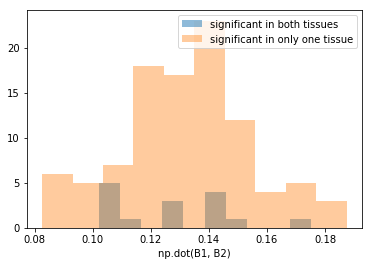

In [129]:
plt.hist(stats, alpha=0.5, label="significant in both tissues")
plt.hist(notcommon_stats, alpha=0.4, label="significant in only one tissue")
plt.xlabel("np.dot(B1, B2)")
plt.legend()
plt.show()

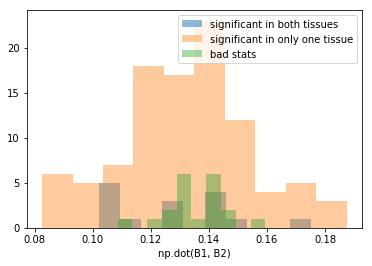

In [153]:
plt.hist(stats, alpha=0.5, label="significant in both tissues")
plt.hist(notcommon_stats, alpha=0.4, label="significant in only one tissue")
plt.hist(bad_stats, alpha=0.4, label="bad stats")
plt.xlabel("np.dot(B1, B2)")
plt.legend()
plt.show()

15858 15659 15212


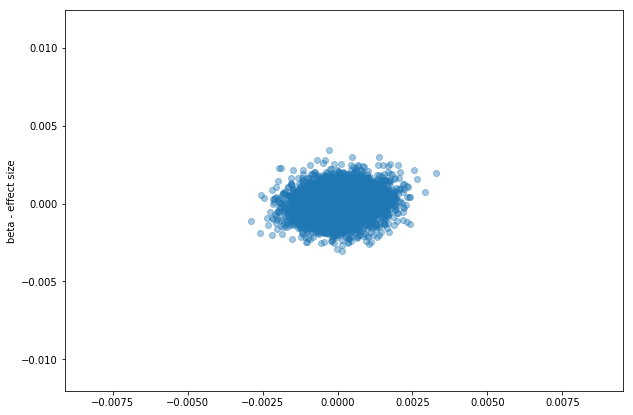

In [110]:
import matplotlib.pyplot as plt

beta0, beta1 = betas[1]
# beta0, beta1 = notcommon_betas[1]

common = [x for x in beta0.genes if x in beta1.genes]
mask0 = np.array([beta0.genes.index(x) for x in common], dtype=int)
mask1 = np.array([beta1.genes.index(x) for x in common], dtype=int)


print(len(beta0.betas), len(beta1.betas), len(common))
cbeta0 = np.array([beta0.betas[i] for i in mask0])
cbeta1 = np.array([beta1.betas[i] for i in mask1])
bigs0 = np.abs(cbeta0) > 0.0025
bigs1 = np.abs(cbeta1) > 0.0025


# x = np.arange(len(bigs0))
x0 = np.arange(np.sum(bigs0))
# x1 = np.arange(np.sum(bigs1))
# x0 = np.arange(len(cbeta0))
# x1 = np.arange(len(cbeta1))

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
# ax.scatter(x0, beta0[bigs0], alpha=0.4)
# ax.scatter(x1, beta1[bigs1], alpha=0.4)
# ax.scatter(x0, cbeta0[bigs0], alpha=0.4)
# ax.scatter(x0, cbeta1[bigs0], alpha=0.4)
ax.scatter(cbeta1, cbeta0, alpha=0.4)
# ax.set_ylim(-0.0045,0.0045)
ax.set_ylabel("beta - effect size")
# ax.set_xlabel("genes")
plt.show()


In [ ]:
ax.scatter(x0, cbeta0[bigs0], alpha=0.4)
ax.scatter(x0, cbeta1[bigs0], alpha=0.4)

In [95]:
betacum0 = np.array([])
betacum1 = np.array([])
for beta0, beta1 in betas:
    cbeta0 = np.array([beta0.betas[i] for i in mask0])
    cbeta1 = np.array([beta1.betas[i] for i in mask1])
    betacum0 = np.append(betacum0, cbeta0)
    betacum1 = np.append(betacum1, cbeta1)
    
notbetacum0 = np.array([])
notbetacum1 = np.array([])
for nbeta0, nbeta1 in notcommon_betas:
    cbeta0 = np.array([nbeta0.betas[i] for i in mask0])
    cbeta1 = np.array([nbeta1.betas[i] for i in mask1])
    notbetacum0 = np.append(betacum0, cbeta0)
    notbetacum1 = np.append(betacum1, cbeta1)

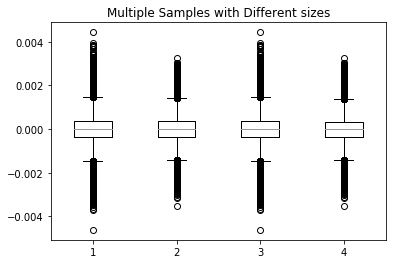

In [99]:
data = [betacum0, betacum1, notbetacum0, notbetacum1]
fig7, ax7 = plt.subplots()
ax7.set_title('Multiple Samples with Different sizes')
ax7.boxplot(data)

plt.show()

In [ ]:
### Too computationally expensive on jupyter

from functools import wraps
import time

def timeit(f):
    @wraps(f)
    def wrap(*args, **kw):
        ts = time.time()
        result = f(*args, **kw)
        te = time.time()
        print('{:s} took: {:.6f} seconds'.format(f.__name__, te-ts))
        return result
    return wrap

def get_gene_masks(beta1file, beta2file):
    genes1 = getheader(beta1file)
    genes2 = getheader(beta2file)
    common = [x for x in genes1 if x in genes2]
    mask1 = [genes1.index(x) for x in common]
    mask2 = [genes2.index(x) for x in common]
    return mask1, mask2

@timeit
def calc_stats(beta1file, beta2file):
    st = time.time()
    mask1, mask2 = get_gene_masks(beta1file, beta2file)      
    print("Reading", beta1file)
    B1 = np.loadtxt(beta1file, skiprows=1)
    t1 = time.time()
    print("Reading", beta2file)
    B2 = np.loadtxt(beta2file, skiprows=1)
    t2 = time.time()
    print("Calculating einsum")
    stats = einsum('ij,ij->i', B1, B2)
    te = time.time()
    print("Loading took {:d}".format(t2-st))
    print("Calculation took {:d}".format(te-t2))
#     with open(beta1file) as bin1:
#         with open(beta2file) as bin2:
#             _h = bin1.readline()
#             _h = bin2.readline()
#             for l1 in bin1:
#                 l2 = bin2.readline()
#                 b1 = np.array([float(x) for x in l1.rstrip().split()])
#                 b2 = np.array([float(x) for x in l2.rstrip().split()])
#                 g1 = [b1[i] for i in mask1]
#                 g2 = [b2[i] for i in mask2]
#                 stat = np.dot(g1, g2)
#                 stats = np.append(stats, stat)
    return stats

d1 = 'gtex-bca'
d2 = 'gtex-bce'
selections = [d1, d2]

tissue_chunks = collections.defaultdict(dict)
for dd in selections:
    for chrom in chrms:
        respath = os.path.join("/cbscratch/franco/trans-eqtl/dev-pipeline/with_betas/lmcorrected/", dd, "tejaas", "permnull_sb"+sb, "chr"+str(chrom))
        filelist = os.listdir(respath)
        nchunks = len([os.path.join(respath,x) for x in filelist if x.startswith("chunk") and x.endswith("rr.txt")])
        rr_chunks = [os.path.join(respath, "chunk{0:03d}_rr.txt".format(x)) for x in range(0,nchunks)]
        beta_chunks = [os.path.join(respath, "chunk{0:03d}_betas.txt".format(x)) for x in range(0,nchunks)]
        filechunks = list(zip(rr_chunks, beta_chunks))
        tissue_chunks[dd][chrom] = filechunks

if len(selections) == 2:
    t1 = selections[0]
    t2 = selections[1]
    
    Bstats = np.array([])
    for chrom in chrms:
        filelist1 = tissue_chunks[t1][chrom]
        filelist2 = tissue_chunks[t2][chrom]
        if len(filelist2) == len(filelist1):
            for i in range(len(filelist1)):
                rr1file = filelist1[i][0]
                rr2file = filelist2[i][0]
                beta1file = filelist1[i][1]
                beta2file = filelist2[i][1]
                stats = calc_stats(beta1file, beta2file)
                Bstats = np.append(Bstats, stats)                
        else:
            print("ERROR filelist size does not match across tissues")


Reading /cbscratch/franco/trans-eqtl/dev-pipeline/with_betas/lmcorrected/gtex-bca/tejaas/permnull_sb0.05/chr6/chunk000_betas.txt
